In [81]:
import cv2
from matplotlib import pyplot as plt
import albumentations as A
import torch
import numpy as np
from tqdm import tqdm
import time

plt.rcParams["figure.figsize"] = (15, 15)

In [21]:
!pip install -U retinaface_pytorch > /dev/null

# '> /dev/null' in pip install:
# '>' redirects the standard output to any file you desire - terminal shows only the errors
# '/dev/null' is a virtual file that anything you put there is deleted
# https://www.kaggle.com/questions-and-answers/170784#950063

# original repo: https://github.com/deepinsight/insightface/tree/master/detection/retinaface
# implementation of above: https://github.com/biubug6/Pytorch_Retinaface
# remake of above: https://github.com/ternaus/retinaface

# retinaface.pre_trained_models 
# -> get_model 
# -> "resnet50_2020-07-20" 
# -> load_url 
# -> load_state_dict

In [22]:
from retinaface.pre_trained_models import get_model as get_detector
from retinaface.utils import vis_annotations

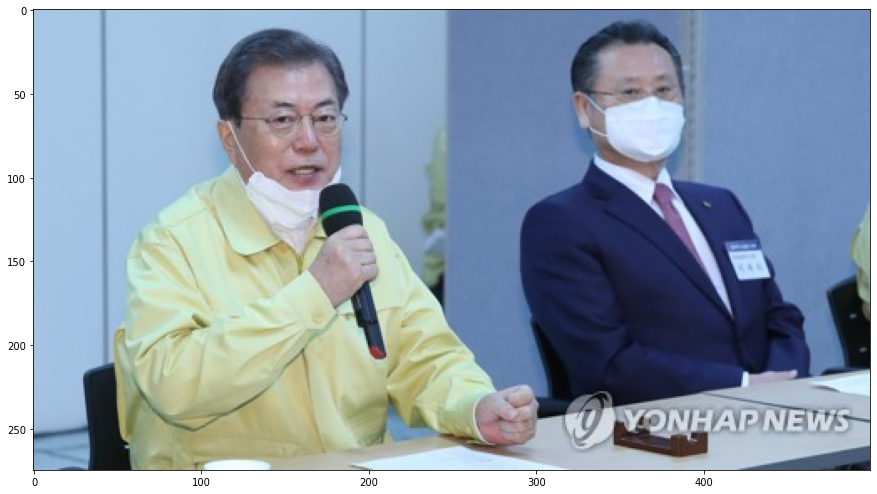

In [74]:
image = cv2.imread("test_9.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [91]:
face_detector = get_detector("resnet50_2020-07-20", max_size=2048)
face_detector.eval()

print(type(face_detector))

<class 'retinaface.predict_single.Model'>


2.8762691020965576
2
{'bbox': [334.01, 19.8, 387.73, 89.94], 'score': 1.0, 'landmarks': [[355.49, 49.46], [377.75, 47.03], [371.05, 61.17], [359.39, 71.79], [378.51, 69.83]]}


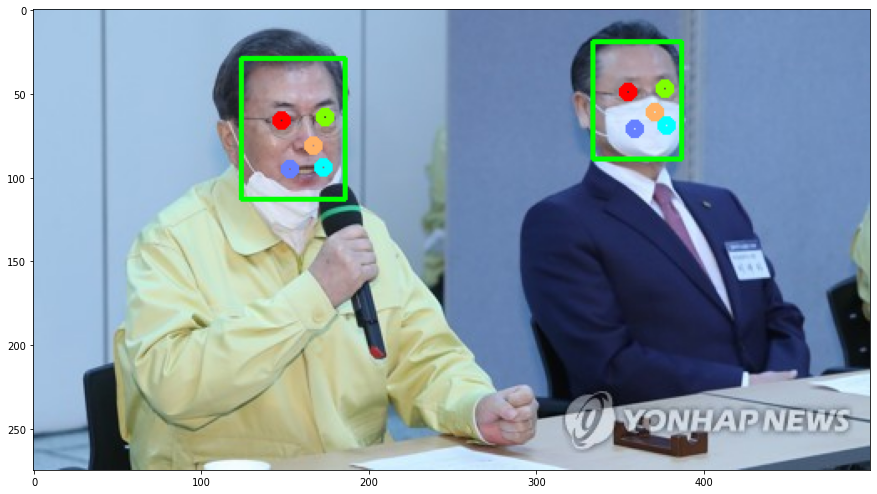

In [82]:
start = time.time()
with torch.no_grad():
    annotations = face_detector.predict_jsons(image)
end = time.time()
print(end-start)
print(len(annotations))
print(annotations[0])

plt.imshow(vis_annotations(image, annotations))

In [26]:
!pip install facemask_detection  > /dev/null

# https://github.com/ternaus/facemask_detection

# facemask_detection.pre_trained_models
# -> get_model
# -> "tf_efficientnet_b0_ns_2020-07-29"
# -> timm.create_model
# -> load_url 
# -> load_state_dict

In [27]:
from facemask_detection.pre_trained_models import get_model as get_classifier

In [89]:
mask_classifier = get_classifier("tf_efficientnet_b0_ns_2020-07-29")
mask_classifier.eval()

print(type(mask_classifier))

<class 'torch.nn.modules.container.Sequential'>


In [32]:
transform = A.Compose([A.SmallestMaxSize(max_size=256, p=1), 
                       A.CenterCrop(height=224, width=224, p=1),
                       A.Normalize(p=1)])

In [76]:
# face bboxes are feeded into mask classifier

predictions = []

with torch.no_grad():
    for annotation in tqdm(annotations):
        x_min, y_min, x_max, y_max = annotation['bbox']

        x_min = int(np.clip(x_min, 0, x_max))
        y_min = int(np.clip(y_min, 0, y_max))
        x_max = int(x_max)
        y_max = int(y_max)

        crop = image[y_min:y_max, x_min:x_max]

        crop_transformed = transform(image=crop)['image']
        model_input = torch.from_numpy(np.transpose(crop_transformed, (2, 0, 1)))

        predictions += [mask_classifier(model_input.unsqueeze(0))[0].item()]

100%|██████████| 2/2 [00:00<00:00, 32.10it/s]


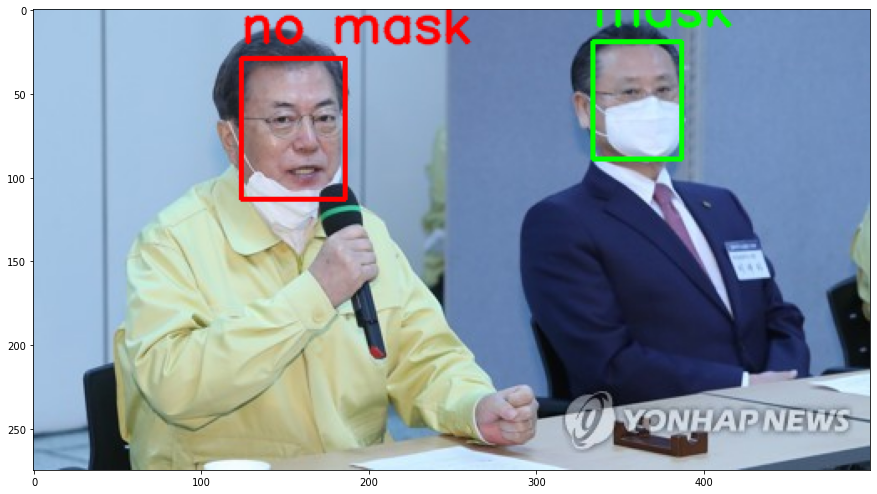

In [79]:
# bboxes and texts are drawn onto copied image

vis_image = image.copy()

for prediction_id, annotation in enumerate(annotations):
    if predictions[prediction_id]>0.5:
        color = (0, 255, 0)
        text = "mask"
    else:
        color = (255, 0, 0)
        text = "no mask"

    x_min, y_min, x_max, y_max = annotation['bbox']

    x_min = int(np.clip(x_min, 0, x_max-1))
    y_min = int(np.clip(y_min, 0, y_max-1))
    x_max = int(x_max)
    y_max = int(y_max)

    vis_image = cv2.rectangle(vis_image, (x_min, y_min), (x_max, y_max), color=color, thickness=2)
    vis_image = cv2.putText(vis_image, text, (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA) 

plt.imshow(vis_image)